<a href="https://colab.research.google.com/github/helmieresearch/helmieresearch/blob/main/Zipline_Reloaded_BacktestEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧰**INSTALL MODULES**

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Install ta-lib v0.4.0
%%bash
wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
tar -xzf ta-lib-0.4.0-src.tar.gz
cd ta-lib/
./configure
make
make install

In [ ]:
# Install zipline
%pip install zipline-reloaded

In [ ]:
!pip install iso3166==2.0.2

In [ ]:
# Install Pyfolio
!pip install pyfolio-reloaded

In [ ]:
# Install matplot library
!pip install matplotlib

In [ ]:
# Install data bundle 'Quandl'
!pip install quandl

In [ ]:
import zipline
zipline.__version__

In [ ]:
!pip install nasdaq-data-link

# 💽**SET WORKING DIRECTORY**

In [ ]:
import os 

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/"


In [ ]:
import os 

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!


# choose where you want your project files to be saved
project_folder = "MyDrive/Colab Notebooks/My Project Folder"


In [ ]:
def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)

In [ ]:
# Confirm current working directory
!pwd

In [ ]:
import os
for f in os.listdir("//content/drive/MyDrive/Colab Notebooks/My Project Folder"):
	print(f)

# ⏳**INGEST DATA**

In [ ]:
# Ingest custom bundle
!zipline ingest --bundle 'crypto'

In [ ]:
# Ingest custom bundle
!zipline ingest --bundle 'equities_csvdir'

In [ ]:
# Ingest custom bundle
!zipline ingest --bundle 'random_futures_data'

In [ ]:
# Ingest custom bundle
!zipline ingest --bundle 'random_stock_data'

In [ ]:
'''
INGEST QUANDL STOCK BUNDLE
'''
# Ingest bundle API
!QUANDL_API_KEY=KUnssHvVERHb5XYu9C1- zipline ingest -b 'quandl'

In [ ]:
# Confirm existing bundles
!zipline bundles

In [ ]:
# clean everything older than <date>
!zipline clean -b crypto --after 2022-04-13

# 📊**ANDREAS CLENOW MODELS**

## **Clenow Momentum Model**

---


In [ ]:
#@title
%matplotlib inline

import zipline
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, set_commission, set_slippage, schedule_function, date_rules, time_rules
from pandas import Timestamp
from datetime import datetime
import pytz
import matplotlib.pyplot as plt 
import pyfolio as pf
import pandas as pd 
import numpy as np 
from scipy import stats
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage

#Model Settings

intial_portfolio = 100000
momentum_window = 125
minimum_momentum = 40
portfolio_size = 30
vola_window = 20

#Commission and Slippage Settings

enable_commission = True 
commission_pct = 0.001 
enable_slippage = True 
slippage_volume_limit = 0.025
slippage_impact = 0.05

def momentum_score(ts):

  #Input: Price time series.Output: Annualized exponential regression slope, multiplied by the R2

  # Make a list of consecutive numbers 
  x = np.arange(len(ts))
  # Get logs
  log_ts = np.log(ts)
  # Calculate regression values
  slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts) 
  # Annualize percent
  annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100 
  #Adjust for fitness
  score = annualized_slope * (r_value ** 2) 
  return score

def volatility(ts):
  return ts.pct_change().rolling(vola_window).std().iloc[-1]

def output_progress(context):

  #Output some performance numbers during backtest run 
  #This code just prints out the past month's performance,
  # so that we have something to look at while the backtest runs.

  # Get today's date
  today = zipline.api.get_datetime().date()

  # Calculate percent difference since last month
  perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1

  # Print performance, format as percent with two decimals. 
  print("{} - Last Month Result: {:.2%}".format(today, perf_pct))

  # Remember today's portfolio value for next month's calculation 
  context.last_month = context.portfolio.portfolio_value

#Initialization and trading logic


def initialize(context):

  # Set commission and slippage.
  if enable_commission:
    comm_model = PerDollar(cost=commission_pct) 
  else:
    comm_model = PerDollar(cost=0.0) 
  set_commission(comm_model)
  if enable_slippage: slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit,
price_impact=slippage_impact) 
  else:
    slippage_model=FixedSlippage(spread=0.0) 
  set_slippage(slippage_model)

  # Used only for progress output. 
  context.last_month = intial_portfolio

  # Store index membership
  context.index_members = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/My Project Folder/index members/sp500.csv', engine='python', error_bad_lines=False)


  #Schedule rebalance monthly. 
  schedule_function(
    func=rebalance, 
    date_rule=date_rules.month_start(), 
    time_rule=time_rules.market_open()
  )

def rebalance(context, data):
  # Write some progress output during the backtest 
  output_progress(context)

  # First, get today's date
  today = zipline.api.get_datetime().date()

  # Second, get the index makeup for all days prior to today.
  all_prior = context.index_members.loc[context.index_members.index < today]

  todays_universe = [ 
    symbol(ticker) for ticker in
    context.index_members.loc[context.index_members.index < today].iloc[-1,0].split(',')
  ]

  # Get historical data
  hist = data.history(todays_universe, "close", momentum_window, "1d")

  # Make momentum ranking table
  ranking_table = hist.apply(momentum_score).sort_values(ascending=False)

  #Sell Logic
  #First we check if any existing position should be sold.
    #Sell if stock is no longer part of index.
    #Sell if stock has too low momentum value.

  kept_positions = list(context.portfolio.positions.keys()) 
  for security in context.portfolio.positions:
    if (security not in todays_universe): 
      order_target_percent(security, 0.0) 
      kept_positions.remove(security)
    elif ranking_table[security] < minimum_momentum: 
      order_target_percent(security, 0.0) 
      kept_positions.remove(security)

  #Stock Selection Logic
  #Check how many stocks we are keeping from last month.
  #Fill from top of ranking list, until we reach the desired total number of portfolio holdings.

  replacement_stocks = portfolio_size - len(kept_positions) 
  buy_list = ranking_table.loc[
    ~ranking_table.index.isin(kept_positions)][:replacement_stocks]
  new_portfolio = pd.concat(
    (buy_list,
    ranking_table.loc[ranking_table.index.isin(kept_positions)])
  )
  buy_list = ranking_table.loc[
    ~ranking_table.index.isin(kept_positions)][:replacement_stocks]

  #Calculate inverse volatility for stocks, and make target position weights.

  vola_table = hist[new_portfolio.index].apply(volatility) 
  inv_vola_table = 1 / vola_table
  sum_inv_vola = np.sum(inv_vola_table) 
  vola_target_weights = inv_vola_table / sum_inv_vola
  for security, rank in new_portfolio.iteritems(): 
    weight = vola_target_weights[security]
    if security in kept_positions:
      order_target_percent(security, weight)
    else:
      if ranking_table[security] > minimum_momentum: 
        order_target_percent(security, weight)

def analyze(context, perf):
  perf['max'] = perf.portfolio_value.cummax() 
  perf['dd'] = (perf.portfolio_value / perf['max']) - 1 
  maxdd = perf['dd'].min()

  ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1

  print("Annualized Return: {:.2%} Max Drawdown: {:.2%}".format(ann_ret, maxdd))

  return
'''
start = datetime(1997, 1, 1, 8, 15, 12, 0, pytz.UTC)
end = datetime(2018, 12, 31, 8, 15, 12, 0, pytz.UTC)
'''

start = pd.Timestamp('1997-1-1', tz='utc')
end = pd.Timestamp('2018-12-31', tz='utc')

perf = zipline.run_algorithm(start=start, end=end, 
                             initialize=initialize, 
                             analyze=analyze, 
                             capital_base=intial_portfolio, 
                             data_frequency = 'daily', 
                             bundle='quandl' )

## **Clenow Trend Model**

In [ ]:

%matplotlib inline

import zipline
from zipline.api import future_symbol,  \
    set_commission, set_slippage, schedule_function, date_rules, \
    time_rules, continuous_future, order_target
from pandas import Timestamp
import pytz
import datetime as datetime
import matplotlib.pyplot as plt
import pyfolio as pf
import pandas as pd
import numpy as np  
from zipline.finance.commission import PerTrade, PerContract
from zipline.finance.slippage import VolumeShareSlippage, \
    FixedSlippage, VolatilityVolumeShare

# These lines are for the dynamic text reporting
from IPython.display import display
import ipywidgets as widgets
out = widgets.HTML()
display(out)

"""
Model Settings
"""
starting_portfolio = 50000000
risk_factor = 0.0015
stop_distance = 3
breakout_window = 50
vola_window = 40
slow_ma = 80
fast_ma = 40
enable_commission = True
enable_slippage = True  


def report_result(context, data):
    context.months += 1
    today = zipline.api.get_datetime().date()
    # Calculate annualized return so far
    ann_ret = np.power(context.portfolio.portfolio_value / starting_portfolio, 
                   12 / context.months) - 1
    
    # Update the text
    out.value = """{} We have traded <b>{}</b> months 
    and the annualized return is <b>{:.2%}</b>""".format(today, context.months, ann_ret)

def roll_futures(context, data):
    open_orders = zipline.api.get_open_orders()
    
    for held_contract in context.portfolio.positions:
        # don't roll positions that are set to change by core logic
        if held_contract in open_orders: 
            continue
        
        # Save some time by only checking rolls for
        # contracts stopping trading in the next days
        days_to_auto_close = (
            held_contract.auto_close_date.date() - data.current_session.date()
        ).days
        if days_to_auto_close > 5:
            continue        
        
        # Make a continuation
        continuation = continuous_future(
                held_contract.root_symbol, 
                offset=0, 
                roll='volume', 
                adjustment='mul'
                )
        
        # Get the current contract of the continuation
        continuation_contract = data.current(continuation, 'contract')
        
        if continuation_contract != held_contract:
            # Check how many contracts we hold
            pos_size = context.portfolio.positions[held_contract].amount         
            # Close current position
            order_target(held_contract, 0)
            # Open new position
            order_target(continuation_contract, pos_size)     
            
def position_size(portfolio_value, std, point_value):
    target_variation = portfolio_value * risk_factor
    contract_variation = std * point_value
    contracts = target_variation / contract_variation
    return int(np.nan_to_num(contracts)) 
    
def initialize(context):
    
    """
    Cost Settings
    """
    if enable_commission:
        comm_model = PerContract(cost=0.85, exchange_fee=1.5)
    else:
        comm_model = PerTrade(cost=0.0)
        
    set_commission(us_futures=comm_model)
    
    if enable_slippage:
        slippage_model=VolatilityVolumeShare(volume_limit=0.2)
    else:
        slippage_model=FixedSlippage(spread=0.0)      
        
    set_slippage(us_futures=slippage_model)
    
    """
    Markets to trade
    """ 
    currencies = [
        'AD',
        'BP',
        'CD',
        'CU',
        'DX',
        'JY',
        'NE',
        'SF',
    ]
    
    agricultural = [
        '_C',
        'CT',
        'FC',
        'KC',
        'LR',
        'LS',
        '_O',
        '_S',
        'SB',
        'SM',
        '_W',
    ]
    nonagricultural = [
        'CL',
        'GC',
        'HG',
        'HO',
        'LG',
        'NG',
        'PA',
        'PL',
        'RB',
        'SI',
    ]
    equities = [
        'ES',
        'NK',
        'NQ',
        'TW',
        'VX',
        'YM',
    ]
    rates = [
        'ED',
        'FV',
        'TU',
        'TY',
        'US',
    ]
    
    # Make a list of all the markets
    markets = currencies + agricultural + nonagricultural + equities + rates
    
    # Make a list of all continuations
    context.universe = [
        continuous_future(market, offset=0, roll='volume', adjustment='mul')
            for market in markets
    ]
    
    # We'll use these to keep track of best position reading
    # Used to calculate stop points.
    context.highest_in_position = {market: 0 for market in markets} 
    context.lowest_in_position = {market: 0 for market in markets}    
    
    # Schedule the daily trading
    schedule_function(daily_trade, date_rules.every_day(), time_rules.market_close())
    
    # We'll just use this for the progress output
    # during the backtest. Doesn't impact anything.
    context.months = 0    
    
    # Schedule monthly report output
    schedule_function(
        func=report_result,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    ) 
    
def analyze(context, perf):
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)
    
def daily_trade(context, data):
    # Get continuation data
    hist = data.history(
        context.universe, 
        fields=['close','volume'], 
        frequency='1d', 
        bar_count=250,
    )
    
    # Calculate trend
    hist['trend'] = hist['close'].ewm(span=fast_ma).mean() > hist['close'].ewm(span=slow_ma).mean()    
    
    # Make dictionary of open positions
    open_pos = {
        pos.root_symbol: pos 
        for pos in context.portfolio.positions
    } 
    
    # Iterate markets, check for trades
    for continuation in context.universe:
        
        # Get root symbol of continuation
        root = continuation.root_symbol
        
        # Slice off history for just this market
        h = hist.xs(continuation, 2)
        
        # Get standard deviation
        std = h.close.diff()[-vola_window:].std()

        if root in open_pos: # Position is open

            # Get position
            p = context.portfolio.positions[open_pos[root]]
            
            if p.amount > 0: # Position is long
                if context.highest_in_position[root] == 0: # First day holding the position
                    context.highest_in_position[root] = p.cost_basis
                else:
                    context.highest_in_position[root] = max(
                        h['close'].iloc[-1], context.highest_in_position[root]
                    ) 
                    
                # Calculate stop point
                stop = context.highest_in_position[root] - (std  * stop_distance)
                # Check if stop is hit
                if h.iloc[-1]['close'] < stop:
                    contract = open_pos[root]
                    order_target(contract, 0)
                    context.highest_in_position[root] = 0
                # Check if trend has flipped
                elif h['trend'].iloc[-1] == False:
                    contract = open_pos[root]
                    order_target(contract, 0)
                    context.highest_in_position[root] = 0
                    
            else: # Position is short
                if context.lowest_in_position[root] == 0: # First day holding the position
                    context.lowest_in_position[root] = p.cost_basis
                else:
                    context.lowest_in_position[root] = min(
                        h['close'].iloc[-1], context.lowest_in_position[root]
                    )
                
                # Calculate stop point
                stop = context.lowest_in_position[root] + (std  * stop_distance)
                
                # Check if stop is hit
                if h.iloc[-1]['close'] > stop:
                    contract = open_pos[root]
                    order_target(contract, 0)
                    context.lowest_in_position[root] = 0
                # Check if trend has flipped
                elif h['trend'].iloc[-1] == True:
                    contract = open_pos[root]
                    order_target(contract, 0)
                    context.lowest_in_position[root] = 0                         
        
        else: # No position on
            if h['trend'].iloc[-1]: # Bull trend
                # Check if we just made a new high
                if h['close'][-1] == h[-breakout_window:]['close'].max(): 
                    contract = data.current(continuation, 'contract')

                    contracts_to_trade = position_size( \
                                                       context.portfolio.portfolio_value, \
                                                       std, \
                                                       contract.price_multiplier)
                    
                    # Limit size to 20% of avg. daily volume
                    contracts_cap = int(h['volume'][-20:].mean() * 0.2)
                    contracts_to_trade = min(contracts_to_trade, contracts_cap)
                    
                    # Place the order
                    order_target(contract, contracts_to_trade)
             
            else: # Bear trend
                # Check if we just made a new low
                if h['close'][-1] == h[-breakout_window:]['close'].min(): 
                    contract = data.current(continuation, 'contract')

                    contracts_to_trade = position_size( \
                                                       context.portfolio.portfolio_value, \
                                                       std, \
                                                       contract.price_multiplier)
                    
                    # Limit size to 20% of avg. daily volume
                    contracts_cap = int(h['volume'][-20:].mean() * 0.2)
                    contracts_to_trade = min(contracts_to_trade, contracts_cap)
                    
                    # Place the order
                    order_target(contract, -1 * contracts_to_trade)
    
    # If we have open positions, check for rolls
    if len(open_pos) > 0:   
        roll_futures(context, data)                
                        

start = pd.Timestamp('2003-01-01', tz='utc')
end = pd.Timestamp('2017-12-31', tz='utc')

perf = zipline.run_algorithm(
    start=start, end=end, 
    initialize=initialize, 
    analyze=analyze,
    capital_base=starting_portfolio,  
    data_frequency = 'daily', 
    bundle='random_futures_data' ) 




### 💻**MODEL TESTING**

#**DIGITAL ASSETS PROGRAMME**



## **Systems**

---



### Single Asset Backtest

In [ ]:
# This ensures that our graphs will be shown properly in the notebook.
%matplotlib inline

# Import libraries
import zipline
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import pandas as pd

def initialize(context):
  # Which asset to trade
  context.asset = symbol('btc')
  
  # Moving average window
  context.index_average_window = 100

def handle_data(context, data):
  # Request history for the stock
  btc_hist = data.history(context.asset, "close",
                               context.index_average_window, "1d")
  
  # Check if price is above moving average
  if btc_hist[-1] > btc_hist.mean():
    asset_weight = 1.0
  else:
    asset_weight = 0.0
    # Place order
    order_target_percent(context.asset, asset_weight)

def analyze(context, perf):
  
  fig = plt.figure(figsize=(12, 8))
  
    # First char
  ax = fig.add_subplot(311)
  ax.set_title('Strategy Results')
  ax.semilogy(perf['portfolio_value'], linestyle='-',
              label='Equity Curve', linewidth=3.0)
  ax.legend()
  ax.grid(False)

  # Second chart
  ax = fig.add_subplot(312)
  ax.plot(perf['gross_leverage'],
  label='Exposure', linestyle='-', linewidth=1.0)
  ax.legend()
  ax.grid(True)

  # Third chart
  ax = fig.add_subplot(313)
  ax.plot(perf['returns'], label='Returns', linestyle='-.',
          linewidth=1.0)

### Equal Weight Model

In [ ]:
# This ensures that our graphs will be shown properly in the notebook.
%matplotlib inline

# Import a few libraries we need
from zipline import run_algorithm
from zipline.api import order_target_percent, record, symbol, set_benchmark
import pyfolio as pf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def initialize(context):

  # Which stock to trade

  """
  dji = ["JEC","BBY","MSFT","MCHP","PEP",
         "RAD","PTC","GCO","FAST","CTL",
         "APA","EL","TMK","VVI","HPQ",
         "CMCSA","JCI","T"]

  dji = ["aave","ada","algo","alpha","ant",
         "bal","bat","bch","bnb","bsv",
         "btc"]
  """

  dji = ["btc"]


  # Make a list of symbols from the list of tickers
  context.dji_symbols = [symbol(s) for s in dji]

  # Moving average window
  context.index_average_window = 52
  
def handle_data(context, data):
  
  # Get history for all the stocks
  stock_hist = data.history(context.dji_symbols, "close", context.index_average_window, "1d")

  # Make an empty DataFrame to start with
  stock_analytics = pd.DataFrame()

  # Add column for above or below average
  stock_analytics['above_mean'] = stock_hist.iloc[-1] > stock_hist.mean()

  # Set weight for stocks to buy
  stock_analytics.loc[stock_analytics['above_mean'] == True, 'weight'] = 1/len(context.dji_symbols)

  # Set weight to zero for the rest
  stock_analytics.loc[stock_analytics['above_mean'] == False, 'weight'] = 0.0

  # Iterate each row and place trades
  for stock, analytics in stock_analytics.iterrows():

    # Check if the stock can be traded
    if data.can_trade(stock):

      # Place the trade
      order_target_percent(stock, analytics['weight'])

def analyze(context, perf):

  # Use PyFolio to generate a performance report
  returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

  benchmark_period_return = perf['benchmark_period_return']

  daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1

  # Create tear sheet
  pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=None)

"""

def analyze(context, perf):

  fig = plt.figure(figsize=(12, 8))

  # First chart
  ax = fig.add_subplot(311)
  ax.set_title('Strategy Results')
  ax.plot(perf['portfolio_value'], linestyle='-',
          label='Equity Curve', linewidth=3.0)
  ax.legend()
  ax.grid(False)

  # Second chart
  ax = fig.add_subplot(312)
  ax.plot(perf['gross_leverage'],label='Exposure',
          linestyle='-', linewidth=1.0)
  ax.legend()
  ax.grid(True)
  
  # Third chart
  ax = fig.add_subplot(313)
  ax.plot(perf['returns'], label='Returns', linestyle='-.',
          linewidth=1.0)
  ax.legend()
  ax.grid(True)

  """

# Set start and end date
start_date = pd.Timestamp('2016-05-02', tz='utc')
end_date = pd.Timestamp('2020-05-02', tz='utc')

# Fire off the backtest
perf = run_algorithm(
start=start_date,
end=end_date,
initialize=initialize,
analyze=analyze,
handle_data=handle_data,
capital_base=10000,
data_frequency = 'daily', 
bundle= 'crypto',)

In [ ]:
#Export performance results to disk in csv file

perf.portfolio_value.to_csv('ewm_momentum_model.csv')

### Momentum Model

In [ ]:
#@title

%matplotlib inline

import zipline
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, set_commission, set_slippage, schedule_function, date_rules, time_rules
import matplotlib.pyplot as plt 
import pyfolio as pf
import pandas as pd 
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage


initial_portfolio = 10000
minimum_momentum = 10
portfolio_size = 1
vola_window = 30

def momentum_score(ts):

  #Input: Price time series.Output: Annualized exponential regression slope, multiplied by the R2

  # Make a list of consecutive numbers 
  x = np.arange(len(ts))
  # Get logs
  log_ts = np.log(ts)
  # Calculate regression values
  slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts) 
  # Annualize percent
  annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100 
  #Adjust for fitness
  score = annualized_slope * (r_value ** 2) 
  return score

def volatility(ts):
  return ts.pct_change().rolling(vola_window).std().iloc[-1]


#Initialization and trading logic


def initialize(context):

  context.rolling_window = 100

  #Commission and Slippage Settings

  enable_commission = True 
  commission_pct = 0.001 
  enable_slippage = True 
  slippage_volume_limit = 0.025
  slippage_impact = 0.05

  """
  dji = ["AAVE","ADA","ALPHA","BCH","BTC",
          "DOGE","DOT","ETH","LTC","USDT",
          "XLM","XMR","XRP"]
  """
  dji = ["btc","ltc","eth"]

  
  # Make a list of symbols from the list of tickers
  context.dji_symbols = [symbol(s) for s in dji]

  # Set commission and slippage.
  if enable_commission:
    comm_model = PerDollar(cost=commission_pct) 
  else:
    comm_model = PerDollar(cost=0.0) 
  set_commission(comm_model)
  if enable_slippage: slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit,
price_impact=slippage_impact) 
  else:
    slippage_model=FixedSlippage(spread=0.0) 
  set_slippage(slippage_model)


  #Schedule rebalance monthly. 
  schedule_function(
    func=rebalance, 
    date_rule=date_rules.month_start(), 
    time_rule=time_rules.market_open()
  )

def rebalance(context, data):

  # Get historical data
  hist = data.history(context.dji_symbols, "close", context.rolling_window, "1d")

  # Make momentum ranking table
  ranking_table = hist.apply(momentum_score).sort_values(ascending=False)

  #Sell Logic
  #First we check if any existing position should be sold.
    #Sell if stock is no longer part of index.
    #Sell if stock has too low momentum value.

  kept_positions = list(context.portfolio.positions.keys()) 
  for security in context.portfolio.positions:
    if ranking_table[security] < minimum_momentum: 
      order_target_percent(security, 0.0)
      kept_positions.remove(security)
 
  #Stock Selection Logic
  #Check how many stocks we are keeping from last month.
  #Fill from top of ranking list, until we reach the desired total number of portfolio holdings.

  replacement_stocks = portfolio_size - len(kept_positions) 
  buy_list = ranking_table.loc[
    ~ranking_table.index.isin(kept_positions)][:replacement_stocks]
  new_portfolio = pd.concat(
    (buy_list,
    ranking_table.loc[ranking_table.index.isin(kept_positions)])
  )
  buy_list = ranking_table.loc[
    ~ranking_table.index.isin(kept_positions)][:replacement_stocks]

  #Calculate inverse volatility for stocks, and make target position weights.

  vola_table = hist[new_portfolio.index].apply(volatility) 
  inv_vola_table = 1 / vola_table
  sum_inv_vola = np.sum(inv_vola_table) 
  vola_target_weights = inv_vola_table / sum_inv_vola
  for security, rank in new_portfolio.iteritems(): 
    weight = vola_target_weights[security]
    if security in kept_positions:
      order_target_percent(security, weight)
    else:
      if ranking_table[security] > minimum_momentum: 
        order_target_percent(security, weight)


def analyze(context, perf):
    
  # Use PyFolio to generate a performance report
  returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

  benchmark_period_return = perf['benchmark_period_return']

  daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1

  # Create tear sheet
  pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=None)

start= pd.Timestamp('2015-5-1', tz='utc')
end = pd.Timestamp('2022-5-2', tz='utc')

perf = zipline.run_algorithm(start=start, 
                             end=end, 
                             initialize=initialize, 
                             analyze=analyze, 
                             capital_base=initial_portfolio, 
                             data_frequency='daily',
                             bundle='crypto')

In [ ]:
#Export Performance Result to disk in csv file

perf.portfolio_value.to_csv('crypto_momentum.csv')

### **Model Performance**

# **DATA CLEANING**



## Futures

In [ ]:
# Import modules
import nasdaqdatalink
import quandl
# Get the data for Futures, Continuous Contract #6.
import matplotlib.pyplot as plt
data = quandl.get("CHRIS/CME_YM1",start_date="2017-12-03", end_date="2018-12-03", api_key='WDDHaLh3eG6vrEgiCCqy')

In [ ]:
# Plot the prices
data.Settle.plot()
plt.show()

In [ ]:
#import required libraries
import pandas as pd
from datetime import datetime
import numpy as np

data = data.rename(columns={'Open': 'open','High':'high',
                                'Low':'low','Last':'close',
                                'Volume':'volume','Previous Day Open Interest': 'openinterest'}, index=None)

data['expiration_date'] = '2018-12-21'
data['root_symbol'] = 'YM'
data['symbol'] = 'YMZ18'

new_data = data.drop(['Change', 'Settle',], axis=1)

print(new_data.head())



In [ ]:
new_data.to_csv('/content/drive/MyDrive/Colab Notebooks/My Project Folder/Futures/YMZ18.csv')

## Digital assets

### Adjusting model performace csv data for comparison

In [ ]:
import pandas as pd
import numpy as np

A = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/My Project Folder/Backtests/Raw Model Performance Data/Digital Assets/crypto_momentum.csv', parse_dates=True, index_col=0)

A.index = A.index.strftime('%Y/%m/%d')

header_row = 1

A.columns = A.iloc[header_row]

A

In [ ]:
A.info()

In [ ]:

A.to_csv('/content/drive/MyDrive/Colab Notebooks/My Project Folder/Backtests/crypto_momentum_2.csv')


### Adjusting crypto indices csv data for comparison

In [ ]:
#import required libraries
import pandas as pd
from datetime import datetime
import exchange_calendars as xcals
from zipline import get_calendar
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/My Project Folder/crypto/indices/SPCBDM.csv', encoding='cp1252')
df.info()
print(df)

In [ ]:

df.drop([1355],axis=0, inplace = True )

#Convert 'date' Column to datetime
df['2/28/2017'] = pd.to_datetime(df['2/28/2017'], utc=True)

#Set 'date' column as index
df.set_index('2/28/2017', inplace=True)

# Get all expected trading sessions in new dataframe.
sessions = get_calendar('NYSE').sessions_in_range('2017-02-28', '2022-05-05')

df.index = df.index.strftime('%Y/%m/%d')

header_row = 1

df.columns = df.iloc[header_row]

df.tail(5)
df.info()
df

In [ ]:
df = df[~df.index.duplicated()]
df

In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/My Project Folder/Backtests/SPCBDM_test3.csv')

### Removing weekends from timeseries

In [ ]:
#@title
#Import statements
%matplotlib inline
import pandas as pd
import datetime as dt
import numpy as np

#Load csv file from disc
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/My Project Folder/crypto/crypto_data/DOGE.csv')

#Set date column to datetime
df['time'] = pd.to_datetime(df['time'], errors='coerce')

#Remove weekends from data
df = df[df.time.dt.weekday < 5]

#Set 'date' columns as Index
df.set_index("time", inplace = True)

#display weekday dataframe
df

In [ ]:
#inspect dataframe
df.info()

In [ ]:
#Save dataframe to csv

df.to_csv('/content/drive/MyDrive/Colab Notebooks/My Project Folder/crypto/crypto weekday data/DODGE_weekday.csv')

In [ ]:
#Load final data to file to dataframe
dodge = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/My Project Folder/crypto/crypto weekday data/DODGE_weekday.csv')

print(dodge)



In [ ]:
#Remove weekends from dataframe
btc = usholidays[usholidays.date.dt.weekday < 5]

#Set 'date' column as index
btc.set_index('date', inplace = True)

btc

In [ ]:
#import US holiday calender
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

#Set period between start and end date in dataframe to identify and remove holidays
holidays = calendar().holidays(start='2009-01-05', end='2022-05-24') 
m = raw_data['date'].isin(holidays)
usholidays = raw_data[~m].copy()

#print new dataframe with holidays removed
usholidays

### Adjusting crypto data from **Yahoo Finance** for testing with NYSE trading calender.

In [ ]:
#import required libraries
import pandas as pd
from datetime import datetime
import exchange_calendars as xcals
from zipline import get_calendar
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/My Project Folder/crypto/yahoo_data/yahoo raw data/BTC-USD.csv', parse_dates=True, index_col=0)

# Remove Adj Close Column
new_df = df.drop(['Adj Close'], axis=1)

new_df["Volume"] = new_df["Volume"].astype(float)

#Reset index
new_df.reset_index(inplace = True)

#Convert 'date' Column to datetime
new_df['Date'] = pd.to_datetime(new_df['Date'], utc=True)

#Set 'date' column as index
new_df.set_index('Date', inplace=True)

# Get all expected trading sessions in new dataframe.
sessions = get_calendar('NYSE').sessions_in_range('2009-01-05', '2022-07-07')

# To set the trading session in  new dataframe to the NYSE Calender
btc = new_df.reindex(sessions)

#Reset index again to change the index name
btc.reset_index(inplace = True)

#Rename index column to 'date'
btc = btc.rename(columns={'index': 'trading_date'}, index=None)

#Change date format to Year-Month-Day
btc['trading_date'] =  pd.to_datetime(btc['trading_date']).dt.strftime('%Y-%m-%d')

crypto = btc.dropna()

#Change 'PriceUSD' columns to 'close'
crypto.rename(columns = {'Open':'open',
                      'High':'high',
                      'Low':'low',
                      'Close':'close',
                      'Volume':'volume'}, inplace = True)

crypto.set_index('trading_date', inplace=True)

crypto.info()

crypto.to_csv('/content/drive/MyDrive/Colab Notebooks/My Project Folder/crypto/yahoo_data/yahoo cleaned data/btc.csv')

crypto

### Adjusting crypto data from **Coinmetrics** for testing with NYSE trading calender.

In [ ]:
#import required libraries
import pandas as pd
from datetime import datetime
import exchange_calendars as xcals
from zipline import get_calendar
import numpy as np

#load raw data from file
raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/My Project Folder/crypto/coinmetrics_data/btc.csv', parse_dates=True, index_col=0)

new = raw_data.drop(raw_data.loc[:, :'PriceBTC'].columns, axis=1)


#drop columns not needed. Only closing prices required
new.drop(new.iloc[:, 1:76], inplace = True, axis = 1)

#Add new columns
new['high'] =0
new['low'] =0
new['open'] =0
new['volume'] =0

# Rearrange columns to set timestamp as first column
new = new[['high','open','low','PriceUSD','volume']]

#Change 'PriceUSD' columns to 'close'
new.rename(columns = {'PriceUSD':'close'}, inplace = True)

"""
#Drop row (date) not needed
new=new.drop(['2022-05-25'])
"""

#Fill 'close' column with integer values '0'
new["close"].fillna(0, inplace=True)

#Reset index
new.reset_index(inplace = True)

#Rename time columns to date
new = new.rename(columns={'time': 'date'}, index=None)

#Drop all NaN values from dataframe
new.dropna()

#Convert columns datatype from integer to float
new["high"] = new["high"].astype(float)
new["open"] = new["open"].astype(float)
new["low"] = new["low"].astype(float)
new["volume"] = new["volume"].astype(float)

#Convert 'date' Column to datetime
new['date'] = pd.to_datetime(new['date'], utc=True)

#Set 'date' column as index
new.set_index('date', inplace=True)

# Get all expected trading sessions in new dataframe.
sessions = get_calendar('NYSE').sessions_in_range('2009-01-05', '2022-05-24')

# To set the trading session in  new dataframe to the NYSE Calender
btc = new.reindex(sessions)

#Reset index again to change the index name
btc.reset_index(inplace = True)

#Rename index column to 'date'
btc = btc.rename(columns={'index': 'date'}, index=None)

#Change date format to Year-Month-Day
btc['date'] =  pd.to_datetime(btc['date']).dt.strftime('%Y-%m-%d')

"""
btc.set_index('date', inplace=True)
"""

# Remove two columns name is 'C' and 'D'
df = btc.drop(['high', 'open','low'], axis=1)

df['open'] = df['close'] - (0 * df ['close'])
df['high'] = df['open'] - (0 * df ['open'])
df['low'] = df['high'] - (0 * df ['high'])

# Rearrange columns
df = df[['date','open','high','low','close','volume']]

df.set_index('date', inplace=True)

crypto = df.dropna()

crypto.to_csv('/content/drive/MyDrive/Colab Notebooks/My Project Folder/crypto/final crypto bundle/btc.csv')

#**Exploratory Data Analyses (EDA)**

In [ ]:
!pip install mpld3

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sn
import matplotlib.pyplot as plt
"""
import mpld3
mpld3.enable_notebook()
"""
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 2)

In [ ]:
File = pd.read_csv('/content/Stocks_final/ABG.JO.csv', parse_dates=True, index_col=0)

File.info()

print(File.head(5))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5985 entries, 2000-01-04 to 2023-04-21
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   symbol     5985 non-null   object 
 1   open       5985 non-null   float64
 2   high       5985 non-null   float64
 3   low        5985 non-null   float64
 4   close      5985 non-null   float64
 5   volume     5985 non-null   float64
 6   adjclose   5985 non-null   float64
 7   dividends  5985 non-null   float64
 8   splits     5985 non-null   float64
dtypes: float64(8), object(1)
memory usage: 467.6+ KB
            symbol    open    high     low   close     volume     adjclose  \
2000-01-04  ABG.JO  2760.0  2830.0  2745.0  2785.0   869505.0  1034.774048   
2000-01-05  ABG.JO  2700.0  2755.0  2650.0  2720.0   616931.0  1010.623230   
2000-01-06  ABG.JO  2720.0  2740.0  2680.0  2695.0   214315.0  1001.334473   
2000-01-07  ABG.JO  2695.0  2800.0  2695.0  2790.0  1290643.0  1036.63

In [ ]:
pd.set_option('display.max_rows', None)

File.describe()

,open,high,low,close,volume,adjclose,dividends,splits
count,5985.000000,5985.000000,5985.000000,5985.000000,5.985000e+03,5985.000000,5985.000000,5985.0
mean,11624.799287,11790.469089,11461.811051,11632.204843,2.094772e+06,7057.481758,2.349875,0.0
std,5004.703577,5070.522794,4942.475365,5007.947753,4.472251e+06,4537.615987,32.887812,0.0
min,2100.000000,2140.000000,2020.000000,2030.000000,0.000000e+00,754.251770,0.000000,0.0
25%,8262.000000,8377.000000,8165.000000,8254.000000,9.843720e+05,3401.565674,0.000000,0.0
50%,13250.000000,13425.000000,13085.000000,13250.000000,1.611326e+06,6565.347656,0.000000,0.0
75%,15300.000000,15499.000000,15063.000000,15300.000000,2.534611e+06,10515.834961,0.000000,0.0
max,21000.000000,21100.000000,20582.000000,20908.000000,2.406311e+08,20160.300781,708.000000,0.0


<Axes: >

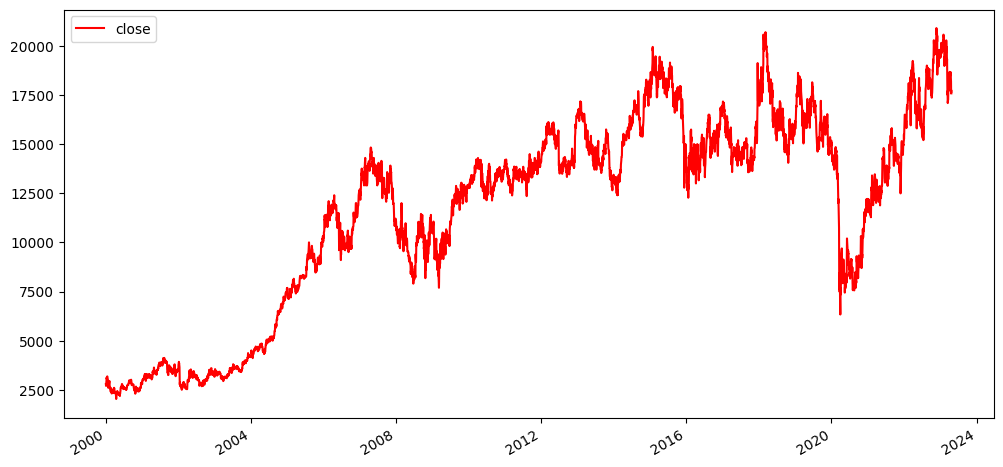

In [ ]:
"""
File['open'].plot(figsize=(12,6), 
                  linestyle='--',color='black',
                  legend='Open')

File['high'].plot(figsize=(12,6),
                   linestyle='-',color='red',
                   legend='High')

File['low'].plot(figsize=(12,6),
                 linestyle=':',color='blue',
                 legend='Low')
"""
File['close'].plot(figsize=(12,6),
                  linestyle='-',color='red',
                  legend='Close')

In [ ]:
no_outlier_prices = File[(np.abs(stats.zscore(File)) <
6).all(axis=1)]

TypeError: ignored

In [ ]:
no_outlier_prices['low'].plot(figsize=(12,6), linestyle='--',
color='black', legend='Low')

NameError: ignored

In [ ]:
pd.set_option('display.max_rows', None)

no_outlier_prices[['533.95']].describe()

# **DOWNLOAD JSE STOCK PRICES USING MARKETSTACK AND YFINANCE**

**Install packages**

In [ ]:
!pip install yfinance

In [ ]:
!pip install yahooquery

**Run programme**

In [6]:
#Import required libraries
import pandas as pd
import json
import requests
from yahooquery import Ticker
from datetime import datetime
params = {'access_key': 'e52cf3b93696352e880916f8c8adbf0c',
          'limit': 350}
api_result = requests.get('http://api.marketstack.com/v1/exchanges/XJSE/tickers', params)
api_response = api_result.json()
print(f"Exchange Name = {api_response['data']['name']}")
for ticker in api_response['data']['tickers']:
  print(f"{ticker['name']}: {ticker['symbol']}")


# Serializing json
json_object = json.dumps(api_response, indent=4)
# Writing to sample.json
with open("jse.json", "w") as outfile:
    outfile.write(json_object)
# Opening JSON file
with open('jse.json', 'r') as openfile:
    # Reading from json file
    json_object = json.load(openfile)
df1 = pd.json_normalize(json_object["data"]["tickers"])

# dropping null value columns to avoid errors
# new data frame with split value columns
new = df1["symbol"].str.split(".", n = 1, expand = True)
# making separate first name column from new data frame
df1["ticker"]= new[0]
# Dropping old Name columns
df1.drop(columns =["has_intraday","has_eod"], inplace = True)
new.columns = new.columns.astype(str)
new.columns.values[1] = "tickers"
new['0'] + '.' + new['tickers']
new.replace("XJSE", "JO", inplace=True)

result = pd.concat([df1, new], axis=1, join='inner')
df2=result['0'] + '.' + result['tickers']
final = pd.concat([df1, df2], axis=1, join='inner')
final.columns.values[3] = "tickers"
final.columns = final.columns.astype(str)
#Dropping old Name columns
final.drop(columns =["name", "symbol","ticker"], inplace = True)
# Converting a specific Dataframe 
# column to list using Series.tolist()
xjse = final["tickers"].tolist()  
print("Converting tickers to list...")
print("Output dataframe..." )
print("Writing csv file..." )
print("Saving JSE data to disc...")
print("Saving csv files for each stock to disc...")  
symbols = xjse
tickers = Ticker(symbols, asynchronous=True)
data = tickers.history(start='1998-01-01', end='2023-04-22', interval='1d')
data= data.drop(['adjclose','dividends','splits'],axis=1)


#Convert dataframe to csv and save to disc
final.to_csv("tickers.csv")
data.to_csv("jse_stocks.csv")

resetindex = data.reset_index(inplace = True) 

for i, g in data.groupby('symbol'):
    g.to_csv('/content/Stocks/{}.csv'.format(i), header=True, index_label=False)

Exchange Name = Johannesburg Stock Exchange
PROSUS N.V.: PRX.XJSE
ANHEUSER-BUSCH INBEV SA NV: ANH.XJSE
BHP GROUP PLC: BHP.XJSE
BRITISH AMERICAN TOB PLC: BTI.XJSE
NASPERS LTD -N-: NPN.XJSE
COMPAGNIE FIN RICHEMONT: CFR.XJSE
GLENCORE PLC: GLN.XJSE
ANGLO AMERICAN PLC: AGL.XJSE
FIRSTRAND LTD: FSR.XJSE
ANGLO AMERICAN PLAT LTD: AMS.XJSE
STANDARD BANK GROUP LTD: SBK.XJSE
VODACOM GROUP LTD: VOD.XJSE
MONDI PLC: MNP.XJSE
CAPITEC BANK HLDGS LTD: CPI.XJSE
BEE - SASOL LIMITED: SOLBE1.XJSE
SANLAM LIMITED: SLM.XJSE
MTN GROUP LTD: MTN.XJSE
ANGLOGOLD ASHANTI LTD: ANG.XJSE
SASOL LIMITED: SOL.XJSE
ABSA GROUP LIMITED: ABG.XJSE
SOUTH32 LIMITED: S32.XJSE
RMB HOLDINGS LTD: RMH.XJSE
IMPALA PLATINUM HLGS LTD: IMP.XJSE
BID CORPORATION LTD: BID.XJSE
REMGRO LTD: REM.XJSE
KUMBA IRON ORE LTD: KIO.XJSE
NEDBANK GROUP LTD: NED.XJSE
SIBANYE STILLWATER LTD: SSW.XJSE
GOLD FIELDS LTD: GFI.XJSE
INVESTEC LTD: INL.XJSE
INVESTEC PLC: INP.XJSE
OLD MUTUAL LIMITED: OMU.XJSE
NEPI ROCKCASTLE PLC: NRP.XJSE
DISCOVERY LTD: DSY.XJSE
SH

In [8]:
SLM = pd.read_csv('/content/Stocks/SLM.JO.csv')
SLM.info()
SLM

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5976 entries, 65341 to 71316
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  5976 non-null   object 
 1   date    5976 non-null   object 
 2   open    5976 non-null   float64
 3   high    5976 non-null   float64
 4   low     5976 non-null   float64
 5   close   5976 non-null   float64
 6   volume  5976 non-null   float64
dtypes: float64(5), object(2)
memory usage: 373.5+ KB


,symbol,date,open,high,low,close,volume
65341,SLM.JO,2000-01-17 02:00:00+02:00,980.0,995.0,959.0,977.0,6503053.0
65342,SLM.JO,2000-01-18 02:00:00+02:00,980.0,1000.0,960.0,978.0,10431653.0
65343,SLM.JO,2000-01-19 02:00:00+02:00,970.0,975.0,940.0,955.0,2108933.0
65344,SLM.JO,2000-01-20 02:00:00+02:00,955.0,1020.0,955.0,993.0,10787166.0
65345,SLM.JO,2000-01-21 02:00:00+02:00,985.0,990.0,965.0,980.0,4339661.0
...,...,...,...,...,...,...,...
71312,SLM.JO,2023-04-17 02:00:00+02:00,5600.0,5681.0,5558.0,5606.0,4600726.0
71313,SLM.JO,2023-04-18 02:00:00+02:00,5650.0,5649.0,5575.0,5615.0,4231146.0
71314,SLM.JO,2023-04-19 02:00:00+02:00,5575.0,5690.0,5528.0,5670.0,3800703.0
71315,SLM.JO,2023-04-20 02:00:00+02:00,5690.0,5712.0,5588.0,5645.0,4664703.0


#**TEST CODE HERE**

In [ ]:
import pandas as pd
import yfinance as yf
JSE = {} 
tickers = Stocks
for t in tickers:
    ticker = yf.Ticker(t)
    JSE[t] = ticker.history(period="2y")
print(JSE)

In [ ]:
import yfinance as yf
from datetime import date, timedelta

stock_list = Stocks

# Specify start dates and end dates
end_date = date.today()
start_date = end_date - timedelta(days=252)
print('start_date:', start_date)
print('end_date:', end_date)

start_date_list = [start_date + timedelta(days=7*i) for i in range(5)]
print('start_date_list:', start_date_list)
end_date_list = [start_date_list[i+1] - timedelta(days=1) for i in range(4)] + [end_date]
print('end_date_list:', end_date_list)
print('===========================================================')

# Use for-loop to extract data
df_1min = pd.DataFrame({})
for idx in range(5):
    data = yf.download(stock_list, 
                       start=start_date_list[idx].strftime("%Y-%m-%d"), 
                       end=end_date_list[idx].strftime("%Y-%m-%d"), 
                       interval = "1d")
    df_1min = df_1min.append(data)
df_1min

In [ ]:
import json
import pandas as pd
def flatten_nested_json_df(df):
    df = df.reset_index()
    s = (df.applymap(type) == list).all()
    list_columns = s[s].index.tolist()
    
    s = (df.applymap(type) == dict).all()
    dict_columns = s[s].index.tolist()

    
    while len(list_columns) > 0 or len(dict_columns) > 0:
        new_columns = []

        for col in dict_columns:
            horiz_exploded = pd.json_normalize(df[col]).add_prefix(f'{col}.')
            horiz_exploded.index = df.index
            df = pd.concat([df, horiz_exploded], axis=1).drop(columns=[col])
            new_columns.extend(horiz_exploded.columns) # inplace

        for col in list_columns:
            #print(f"exploding: {col}")
            df = df.drop(columns=[col]).join(df[col].explode().to_frame())
            new_columns.append(col)

        s = (df[new_columns].applymap(type) == list).all()
        list_columns = s[s].index.tolist()

        s = (df[new_columns].applymap(type) == dict).all()
        dict_columns = s[s].index.tolist()
    return df

In [ ]:
jsonString = json.dumps(api_response)  #What you gave is not really a json string but a list
jsonstr = json.loads(jsonString)
results = pd.json_normalize(jsonstr)
df = pd.DataFrame(results)

outdf = flatten_nested_json_df(df)

In [ ]:
outdf

In [ ]:

csv_file_list = glob.glob(Dir + '/content/')
with open(Avg_Dir + '.csv','w') as wf:
    for file in csv_file_list:
        with open(file) as rf:
            for line in rf:
                if line.strip(): # if line is not empty
                    if not line.endswith("\n"):
                        line+="\n"
                    wf.write(line)